In [38]:
# Connect Faster GPUs
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec  4 20:55:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 27.4 gigabytes of available RAM



In [40]:
# Загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import Image 
import random

from tensorflow.keras import utils
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense,\
Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D
from keras.losses import MAE
import keras.backend as K
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

%matplotlib inline
sns.set_style('darkgrid')

In [41]:
# Подключаем диск     
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Считываем данные с помощью pandas
data = pd.read_csv('/content/drive/MyDrive/datasets/date_csv/traff.csv',header=None)


In [43]:
data = data.iloc[:,1]
data.head()

0    22,226.00
1    29,593.00
2    31,726.00
3    32,684.00
4    31,820.00
Name: 1, dtype: object

In [44]:
# Превращаем в numpy массив
data = np.array(data) 
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

In [45]:
#Формируем параметры загрузки данных
xLen = 60     
valLen = 300
 
# Размер тренировочной выборки
trainLen = data.shape[0]-valLen 

# Делим данные на тренировочную и тестовую выборки 
Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)


# Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(Train, Train, length=xLen, sampling_rate=1, batch_size=20)           
                                                                             
# Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=20)


In [46]:
# Функция рассчитываем результаты прогнозирования сети
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(figsize=(18,10))
  plt.plot(predVal[start:start+step, channel], label='Прогноз')          
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')        
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  ma = a.mean() 
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))
    own_corr = []
  for i in range(corrSteps):
    own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))
    if showGraf: 
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')
  if showGraf:
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()
  if returnData: 
    return corr, own_corr


In [47]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=len(Test))

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [48]:
#Создаём сеть (net - список параметров)
def createConvNet(net):
  model = Sequential()             
  
  makeFirstNormalization = net[0]  
  firstConvSize = 2 ** net[1]      
  firstConvKernel = net[2]         
  activation0 = net[3]             
  makeMaxPooling0 = net[4]         
  maxPoolingSize0 = net[5]         

  makeSecondConv = net[6]          
  secondConvSize = 2 ** net[7]     
  secondConvKernel = net[8]        
  makeMaxPooling1 = net[9]         
  maxPoolingSize1 = net[10]     
  activation1 = net[11]         

  makeThirdConv = net[12]
  thirdConvSize = 2 ** net[13]     
  thirdConvKernel = net[14]        
  makeMaxPooling2 = net[15]        
  maxPoolingSize2 = net[16]        
  activation2 = net[17]            

  activation3 = net[18]            
  activation4 = net[19]    

  makeSecondNormalization = net[20] 
  denseSize = 2 ** net[21]

  activation_list = ['linear','relu','tanh','softmax','sigmoid'] 
  # Если делаем нормализацию в начале
  if (makeFirstNormalization):      
    # Добавляем слой BatchNormalization
    model.add(BatchNormalization(input_shape=(xLen, 1))) 
    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same')) 
  else:
    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same')) 
  if makeMaxPooling0:              
    model.add(MaxPooling1D(maxPoolingSize0))
  if (makeSecondConv):
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same')) 
    # Если делаем MaxPooling
    if (makeMaxPooling1):           
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize1)) 
  # Если делаем второй свёрточный слой
  if (makeThirdConv):               
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same')) 
    # Если делаем MaxPooling
    if (makeMaxPooling2):           
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize, maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize2)) 
  # Если делаем финальную нормализацию        
  if (makeSecondNormalization): 
    # Добавляем слой BatchNormalization  
    model.add(BatchNormalization()) 
    # Добавляем слой Flatten
  model.add(Flatten())              
  # Добавляем слой Dense с denseSize нейронами
  model.add(Dense(denseSize, activation=activation_list[activation3])) 
  # Добавляем Dense-слой с softmax-активацией и 10 нейронами
  model.add(Dense(1, activation=activation_list[activation4]))         
  # Возвращаем модель
  return model                      

# Функция вычисления результата работы сети
def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  # Создаем модель createConvNet
  model = createConvNet(net) 
  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-4), loss='mse')
  history = model.fit(trainDataGen, epochs=ep, verbose=verb, validation_data=testDataGen)
  # Возвращаем точность на проверочной выборке с последней эпохи                   
  val = history.history["val_loss"][-1] 
  # Возвращаем точность
  return val, model                      


# Функция создания списка случайных параметров
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) #Делаем или нет нормализацию
  net.append(random.randint(3,6)) #Первый свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) #Ядро первого свёрточного слоя от 3 до 7
  net.append(random.randint(0,4)) # Функция активации первого слоя
  net.append(random.randint(0,1)) #Делаем ли MaxPooling
  net.append(random.randint(2,5)) #Размер MaxPooling

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,6)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,5)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,6)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,5)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,4)) # Функция активации предпоследнего dense слоя
  net.append(random.randint(0,2)) # Функция активации последнего слоя

  net.append(random.randint(0,1)) # Делаем ли финальную нормализацию слой
  net.append(random.randint(3,6)) # Размер полносвязного слоя от 8 до 64
  
  return net

In [49]:
n = 20              # Общее число ботов
nsurv = 10          # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 22              # Размер бота
epohs = 10          # количество эпох
mut = 0.09          # коэфициент мутаций
popul = []          # Массив популяции
val = []            # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):                 # Пробегаем по всем эпохам
  val = []                              # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):                    # Пробегаем в цикле по всем ботам 
    bot = popul[i]                      # Берем очередного бота
    f, model_sum = evaluateNet(bot, 3, 0) # Вычисляем точность текущего бота
    val.append(f)                       # Добавляем полученное значение в список val
  
  sval = sorted(val, reverse=0)         # Сортируем val
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)      
      x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

0 31.735283851623535   [0.03294949233531952, 0.0772572010755539, 0.09675654768943787, 0.10471248626708984, 0.12991753220558167] [[1, 6, 6, 4, 1, 5, 0, 5, 5, 0, 4, 2, 0, 4, 3, 0, 2, 1, 2, 0, 1, 3], [1, 6, 4, 1, 0, 2, 0, 3, 7, 0, 3, 4, 0, 3, 3, 1, 4, 4, 1, 0, 0, 6], [0, 5, 6, 4, 1, 4, 1, 3, 6, 0, 5, 2, 0, 5, 5, 1, 4, 4, 3, 2, 0, 4], [1, 5, 5, 0, 0, 2, 1, 5, 5, 0, 4, 3, 1, 5, 4, 1, 4, 0, 4, 0, 1, 6], [1, 6, 7, 0, 0, 4, 0, 6, 5, 1, 3, 2, 0, 6, 5, 1, 3, 2, 1, 1, 1, 5]]
1 22.067639350891113   [0.017114508897066116, 0.021508583799004555, 0.040335770696401596, 0.04957076907157898, 0.10495305806398392] [[0, 5, 4, 0, 1, 3, 0, 6, 3, 1, 2, 2, 0, 3, 6, 1, 2, 0, 1, 0, 0, 3], [0, 4, 3, 0, 0, 3, 1, 6, 4, 0, 5, 3, 0, 5, 4, 0, 2, 3, 1, 1, 0, 5], [1, 4, 6, 4, 1, 2, 1, 5, 6, 1, 5, 3, 1, 6, 3, 0, 3, 2, 2, 1, 0, 6], [0, 5, 6, 4, 1, 4, 1, 3, 6, 0, 5, 2, 0, 5, 5, 1, 4, 4, 3, 2, 0, 4], [1, 6, 4, 1, 0, 2, 0, 3, 7, 0, 3, 4, 0, 3, 3, 1, 4, 4, 1, 0, 0, 6]]
2 20.319206953048706   [0.014392214827239513, 0.0192864127

In [50]:
#Геномы лучших ботов по эпохам
print(popul) 

[[0, 6, 4, 0, 1, 3, 0, 6, 5, 1, 2, 2, 0, 5, 6, 1, 4, 3, 1, 0, 0, 4], [0, 5, 6, 1, 1, 3, 1, 6, 6, 1, 2, 2, 0, 5, 6, 1, 5, 0, 1, 1, 0, 4], [0, 5, 6, 1, 1, 3, 1, 6, 6, 1, 2, 2, 0, 5, 6, 1, 5, 0, 1, 1, 0, 4], [0, 6, 6, 1, 1, 4, 0, 6, 4, 0, 2, 1, 0, 3, 6, 1, 5, 4, 1, 0, 0, 4], [0, 5, 6, 1, 1, 3, 1, 6, 6, 1, 2, 2, 0, 5, 5, 1, 5, 0, 1, 0, 0, 3], [0, 6, 4, 1, 1, 3, 1, 6, 6, 1, 4, 2, 0, 5, 6, 1, 4, 4, 1, 0, 0, 4], [0, 6, 4, 1, 1, 4, 1, 6, 6, 1, 2, 2, 0, 5, 6, 1, 4, 4, 1, 0, 0, 4], [0, 6, 6, 0, 1, 3, 1, 4, 7, 1, 4, 2, 0, 3, 6, 1, 2, 0, 1, 1, 0, 3], [0, 6, 4, 0, 1, 3, 0, 4, 5, 1, 2, 2, 0, 3, 6, 1, 5, 0, 1, 1, 0, 3], [0, 6, 4, 0, 1, 3, 0, 6, 4, 1, 2, 2, 0, 5, 6, 1, 4, 4, 1, 0, 0, 4], [0, 6, 4, 0, 1, 3, 0, 6, 6, 1, 4, 2, 0, 5, 6, 1, 4, 0, 4, 0, 0, 4], [0, 5, 4, 1, 1, 3, 1, 6, 6, 1, 2, 2, 0, 5, 6, 1, 4, 4, 1, 1, 0, 4], [0, 6, 6, 0, 1, 3, 1, 4, 6, 1, 2, 2, 0, 5, 6, 1, 2, 0, 1, 1, 0, 4], [0, 5, 6, 0, 1, 3, 1, 6, 6, 1, 2, 2, 0, 3, 5, 1, 4, 4, 1, 0, 0, 3], [0, 5, 6, 1, 1, 3, 1, 6, 6, 0, 2, 2, 0, 3, 6, 1

In [51]:
model = createConvNet(popul[0])
model.summary()

Model: "sequential_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_322 (Conv1D)          (None, 60, 64)            320       
_________________________________________________________________
max_pooling1d_258 (MaxPoolin (None, 20, 64)            0         
_________________________________________________________________
flatten_200 (Flatten)        (None, 1280)              0         
_________________________________________________________________
dense_400 (Dense)            (None, 16)                20496     
_________________________________________________________________
dense_401 (Dense)            (None, 1)                 17        
Total params: 20,833
Trainable params: 20,833
Non-trainable params: 0
_________________________________________________________________


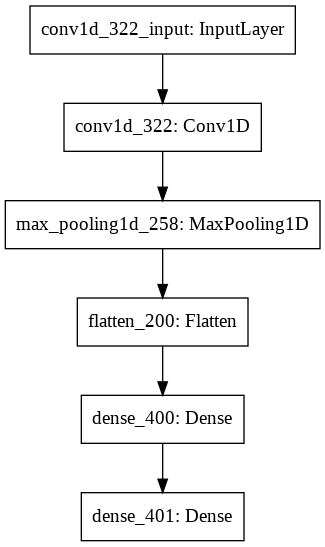

In [52]:
plot_model(model)

In [53]:
#Комипилируем модель
model.compile(optimizer=Adam(lr=1e-4),loss='mse')
# Обучаем модель      
history = model.fit_generator(trainDataGen, epochs=50, validation_data=testDataGen)
                     

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
37/37 [==============================] - 0s 5ms/step - loss: 0.1187 - val_loss: 0.0510
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0194
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0254
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0112 - val_loss: 0.0196
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0203
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0186
Epoch 7/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0157
Epoch 8/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0141
Epoch 9/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0223
Epoch 10/50
37/37 [=======================

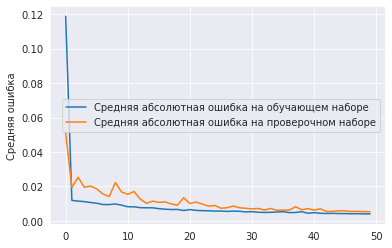

In [54]:
plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

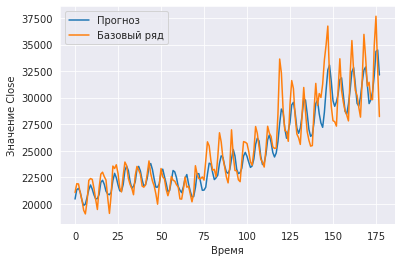

In [55]:
# Прогнозируем данные текущей сетью
currModel = model 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler)

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

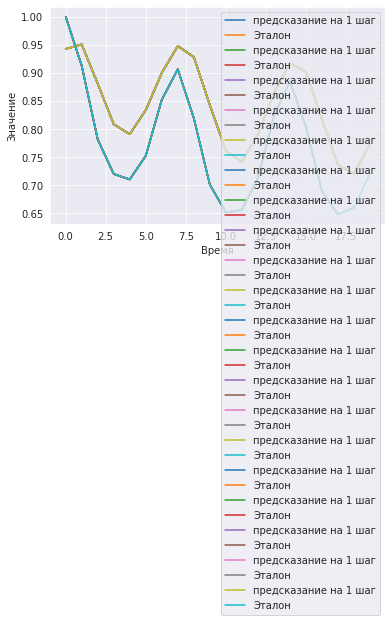

In [56]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 20, predVal, yValUnscaled)